In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## CAMERA CALIBRATION

In order to do camera calibrations, I combine all the neccessary steps in the below functions **calibrate_camera_images**. 


The function take a list of chessboard images and shape as inputs. We first need to convert them to gray scale image and use the OpenCV **findChessBoardCorners** to find all the corners position. We use numpy mgrid to generate a matrix where each row represent each corner of the chessboard coordinates and call **calibrateCamera** function from OpenCV to generate the transformation matrix based on the expected points and corners real position so that we can undistort image later on


In [2]:
def calibrate_camera_images(chessboard_files, shape):
     # calibrate camera here
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane
    for chessboard_file in chessboard_files:
        img = cv2.imread(chessboard_file)
        # convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find corners
        ret, corners = cv2.findChessboardCorners(gray, shape, None)
        # draw corners
        if ret:
            #print("Found corners")
            cv2.drawChessboardCorners(img, shape, corners, ret)
            plt.figure()
            plt.imshow(img)
            # generate image coordinates using mgrid
            objp = np.zeros((shape[0]*shape[1],3),np.float32)
            # fix x,y coordinate
            objp[:,:2] = np.mgrid[0:shape[0],0:shape[1]].T.reshape(-1,2)
            objpoints.append(objp)
            imgpoints.append(corners)
    # now calibrate camera
    ret, mtx, dist, rvect, tvects = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return ret, mtx, dist, rvect, tvects    

### Calibrate Camera Images wiht Given Calibration Images

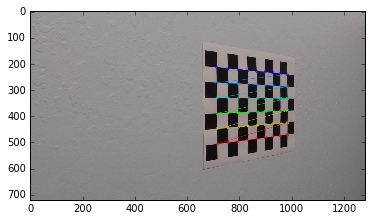

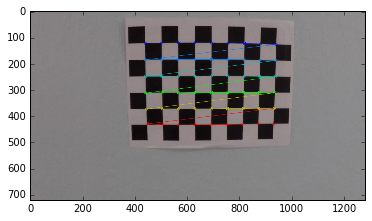

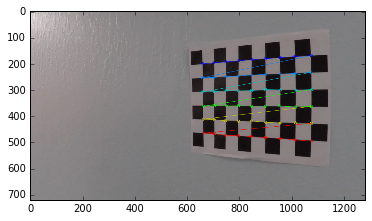

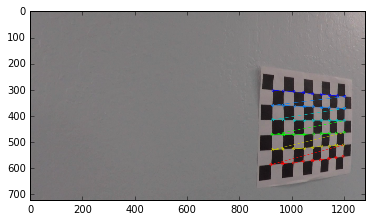

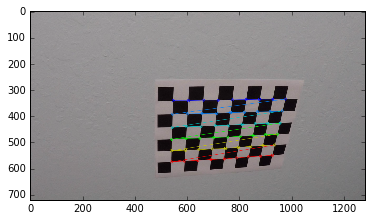

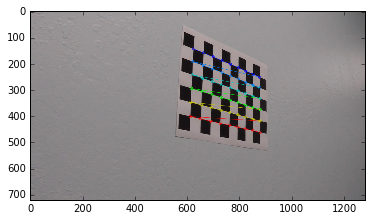

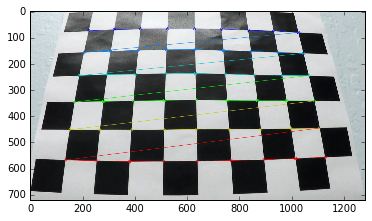

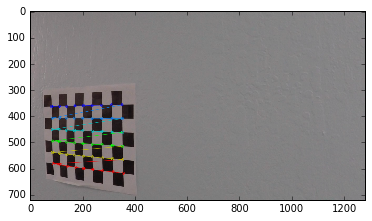

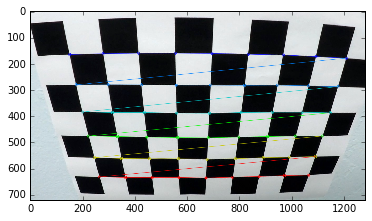

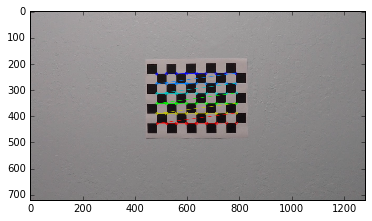

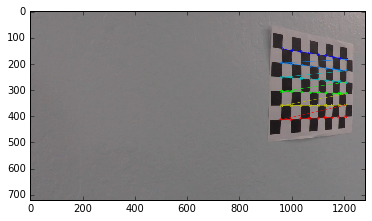

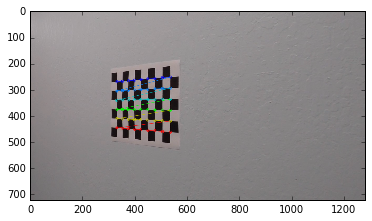

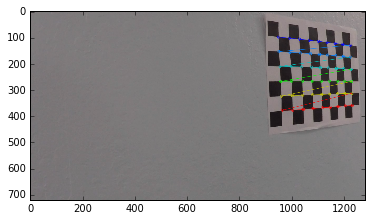

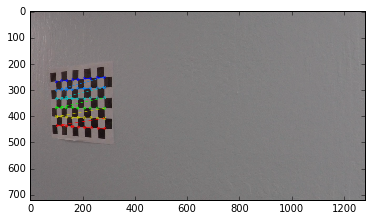

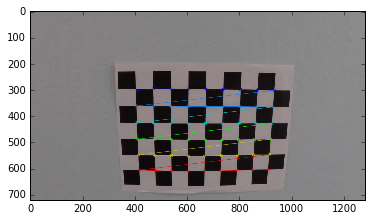

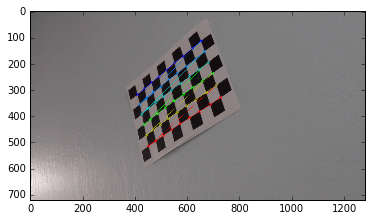

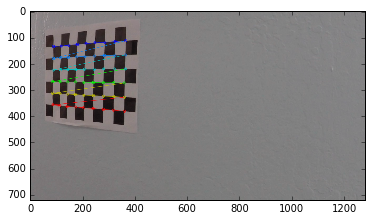

In [3]:
import glob
image_files = glob.glob('camera_cal/*.jpg')
ret, mtx, dist, rvect, tvects = calibrate_camera_images(image_files, (9,6))

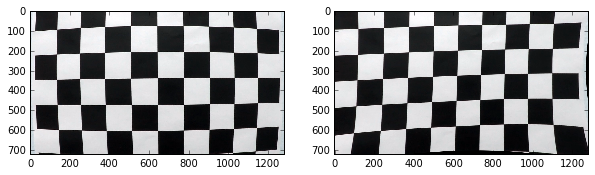

In [4]:
# sample image distort
example_img = cv2.imread('./camera_cal/calibration1.jpg')
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(example_img)
plt.subplot(1, 2, 2)
undistort_img = cv2.undistort(example_img, mtx, dist, None, mtx)
plt.imshow(undistort_img)

## Undistort image Examples

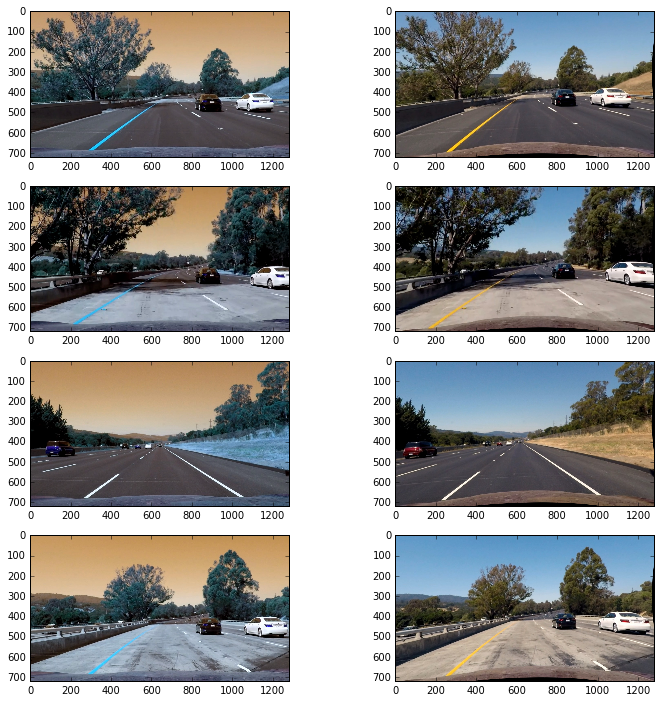

In [5]:
# undistort image here 
undistort_images = []
image_files = glob.glob("test_images/*")
image_files = image_files[0:4]
plt.figure(figsize=(12,12))
for i, image in enumerate(image_files):
    img = cv2.imread(image)
    plt.subplot(len(image_files), 2, i*2+1)
    plt.imshow(img)
    plt.subplot(len(image_files), 2, i*2+2)
    undistort_images.append(cv2.undistort(img, mtx, dist, None, mtx))
    plt.imshow(cv2.cvtColor(undistort_images[-1], cv2.COLOR_BGR2RGB))

It is not easy to see the effects of the transformation. However, we can notice the changes in the shape of the car hood as well as the shape of white cars in those pictures above

## Apply Color and Gradient Thresholds to create binary image

Some helpers to extract specific pixels that meet different criteria to combine into one single binary image 

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        grad_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    else:
        grad_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    scaled_img = np.uint8(grad_img / np.max(grad_img) * 255.0)
    final_img = np.zeros_like(scaled_img)
    final_img[(scaled_img > thresh[0]) & (scaled_img < thresh[1])] = 1
    return final_img

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binaryx_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    binaryy_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    binary_img = np.sqrt(binaryx_img**2 + binaryy_img**2)
    scaled_img = np.uint8(binary_img / np.max(binary_img) * 255.0)
    final_img = np.zeros_like(scaled_img)
    final_img[(scaled_img > mag_thresh[0]) & (scaled_img < mag_thresh[1])] = 1
    return final_img

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binaryx_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    binaryy_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    binary_img = np.arctan2(binaryy_img, binaryx_img)
    final_img = np.zeros_like(binary_img)
    final_img[(binary_img > thresh[0]) & (binary_img < thresh[1])] = 1
    return final_img

# HLS channel thresholding 
def s_channel_thresholding(img, threshold=(95,255)):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_chan = hsv_img[:,:,2]
    binary_img = np.zeros_like(s_chan)
    binary_img [(s_chan > threshold[0]) & (s_chan < threshold[1])] = 1
    return binary_img
    



### EXTRACT SINGLE FEATURE

Absolute Image Threshold


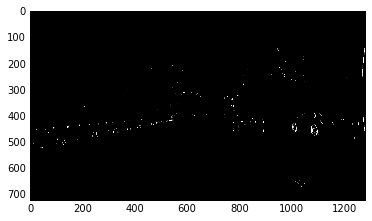

In [7]:
abs_image = abs_sobel_thresh(undistort_images[-1], thresh=(90,255))
print ("Absolute Image Threshold")
plt.figure()
plt.imshow(abs_image, cmap='gray')

Gradient Magnitude Image Threshold


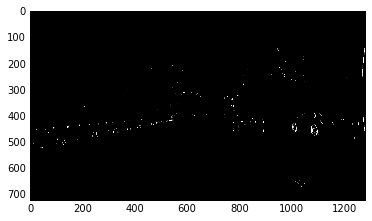

In [8]:
mag_grad_image = mag_thresh(undistort_images[-1], mag_thresh=(110,255))
print ("Gradient Magnitude Image Threshold")
plt.figure()
plt.imshow(abs_image, cmap='gray')

Gradient Direction Image Threshold


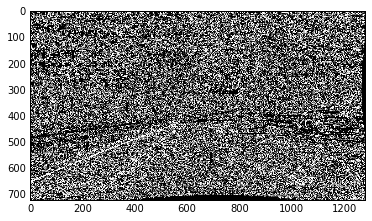

In [9]:
dir_image = dir_threshold(undistort_images[-1], sobel_kernel=15, thresh=(0.7, 1.3))
print ("Gradient Direction Image Threshold")
plt.figure()
plt.imshow(dir_image, cmap='gray')

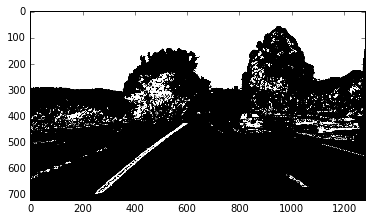

In [10]:
plt.figure()
s_image= s_channel_thresholding(undistort_images[-1], threshold=(95,255))
plt.imshow(s_image, cmap='gray')

### COMBINE ALL MASKS TOGETHER

In [11]:
def threshold_image(img):
    abs_image = abs_sobel_thresh(img, thresh=(90,255))
    mag_grad_image = mag_thresh(img, mag_thresh=(110,255))
    dir_image = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    s_image = s_channel_thresholding(undistort_images[-1], threshold=(95,255))
    shape = img.shape[:2]
    combine_mask_img = np.zeros(shape)
    combine_mask_img[(s_image > 0) | ((mag_grad_image >0) & (dir_image > 0)) | (abs_image > 0)] = 1
    return combine_mask_img

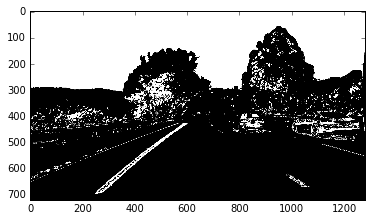

In [12]:
combine_mask_img = threshold_image(undistort_images[-1])
plt.figure()
plt.imshow(combine_mask_img, cmap='gray')

## Performing perspective transform

Experiments with 4 points that cover the shape of the lane in order to find a perfect transformations that can be apply for the whole pipeline. Points are plotted here so it would be easier to visualize and adjust the shape.

[[  520.   450.]
 [  760.   450.]
 [ 1280.   700.]
 [  170.   700.]]


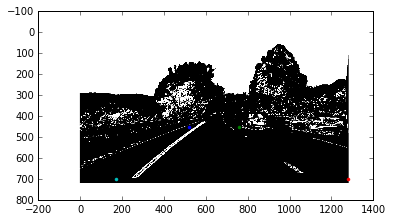

In [13]:
src = np.float32([
        [combine_mask_img.shape[1]/2 - 120, combine_mask_img.shape[0]/1.8 + 50], # tl
        [combine_mask_img.shape[1]/2 + 120, combine_mask_img.shape[0]/1.8 + 50], # tr
        [combine_mask_img.shape[1], combine_mask_img.shape[0] -20], # br
        [170, combine_mask_img.shape[0] - 20] # bl
    ])
print (src)
h, w = combine_mask_img.shape

plt.imshow(combine_mask_img, cmap='gray')
plt.plot(src[0][0], src[0][1], '.')
plt.plot(src[1][0], src[1][1], '.')
plt.plot(src[2][0], src[2][1], '.')
plt.plot(src[3][0], src[3][1], '.')

After finding the correct values for perspective transform, we use the OPENCV **getPerspectiveTransform** to obtain the transformation matrix. The new perspective shape is calculated based on the width and height of the trapezoid formed by the four points that cover the shape of the lanes. 

After obtaining the matrix, we just use **warpPerspective** function from OPENCV again to obtain the new perspective image.

In [22]:
def warp_image(undistort_image, mtx, dist):
    # transform to gray
    #gray = cv2.cvtColor(undistort_image, cv2.COLOR_BGR2GRAY)
    print(undistort_image.shape[1], undistort_image.shape[0])
    width, height = undistort_image.shape[1], undistort_image.shape[0]
    src = np.float32([
        [undistort_image.shape[1]/2 - 120, undistort_image.shape[0]/1.8 + 50], # tl
        [undistort_image.shape[1]/2 + 120, undistort_image.shape[0]/1.8 + 50], # tr
        [undistort_image.shape[1], undistort_image.shape[0] - 20], # br
        [0, undistort_image.shape[0] - 20] # bl
    ])
    tl,tr,br,bl = src
    
    width = int(np.sqrt((bl[0] - br[0])**2 + (bl[1] - br[1])**2))
    height = int(max(np.sqrt((tl[0] - bl[0])**2 + (tl[1] - bl[1])**2), np.sqrt((tr[0] - br[0])**2 + (tr[1] - br[1])**2)))
    dst = np.float32([
        [0,0], # tl
        [width - 1, 0], # tr
        [width - 1, height - 1], # br
        [0, height -1] # bl
    ], dtype='float32')
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undistort_image, M, (width, height), flags=cv2.INTER_LINEAR)
    return warped, M, Minv, (tl,tr,br,bl)

Below are some newly warped images that clearly show the shape of the lane in new perspective.

1280 720
1280 720


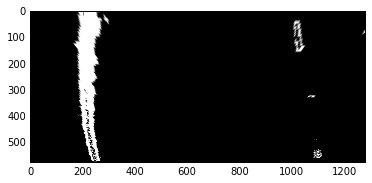

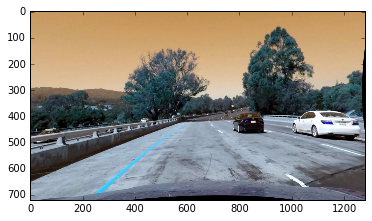

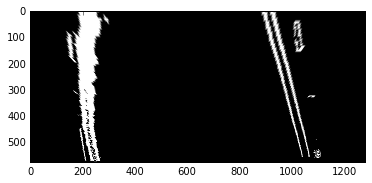

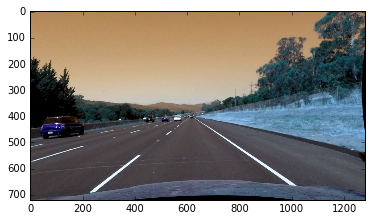

In [23]:
warped = threshold_image(undistort_images[-1])
warped2 = threshold_image(undistort_images[-2])
warped, M, Minv, src = warp_image(warped, mtx, dist)
warped2, M2, M2inv, src2 = warp_image(warped2, mtx, dist)
plt.figure()
plt.imshow(warped, cmap='gray')
plt.figure()
plt.imshow(undistort_images[-1])
plt.figure()
plt.imshow(warped2,cmap='gray')
plt.figure()
plt.imshow(undistort_images[-2])

## Finding lanes using sliding windows approach 

In order to find lanes:
- we first need to calcuclate histogram of nonzero pixels from the warped binary image.
- we needs to find the first peak from left and right which will represent starting points of each lane.
- based on the starting point, we keep a certain windows size to search for nonzero pixel with.
- we keep sliding up each window for each side of the lanes until we reach the top. 
- construct the polygon that represent the shape of the lane then use the invert matrix transformation to cast the shape back into the original image area.


In [16]:
# DEFINE SOME HELPERS FUNCTION TO FIND LANES
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ###Fit a second order polynomial to each with ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1] * ploty + right_fit[2]
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit, margin=100, threshold=0.8):
    nonzero = binary_warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # search around the current left fit and right fit 
    left_lane_x_margin_left = (left_fit[0] * (nonzero_y**2) + left_fit[1] * nonzero_y + left_fit[2] - margin)
    left_lane_x_margin_right = (left_fit[0] * (nonzero_y**2) + left_fit[1] * nonzero_y + left_fit[2] + margin)
    left_lane_ids = (nonzero_x >= left_lane_x_margin_left) & (nonzero_x < left_lane_x_margin_right)
    
    right_lane_x_margin_left = (right_fit[0] * (nonzero_y**2) + right_fit[1] * nonzero_y + right_fit[2] - margin)
    right_lane_x_margin_right = (right_fit[0] * (nonzero_y**2) + right_fit[1] * nonzero_y + right_fit[2] + margin)
    right_lane_ids = (nonzero_x >= right_lane_x_margin_left) & (nonzero_x < right_lane_x_margin_right)
    
    # TODO:
    # if number of pixels ids is smaller than some threshold
    # return none so we will use sliding windows to rediscover the windows
    if (len(left_lane_ids) + len(right_lane_ids)) / np.float(len(nonzero_x)) < threshold:
        return None, None, None, None, None
    
    
    leftx = nonzero_x[left_lane_ids]
    lefty = nonzero_y[left_lane_ids]
    rightx = nonzero_x[right_lane_ids]
    righty = nonzero_y[right_lane_ids]
    
    # now we have the values
    return fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

def plot_x_y(warped_image, left_fit, right_fit):
    # FOR PLOTTING ONLY 
    output_img = np.dstack((warped_image, warped_image, warped_image))
    print(output_img.shape)
    ploty = np.linspace(0, warped_image.shape[0] - 1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    plt.figure(figsize=(10,10))
    plt.imshow(np.uint8(output_img))
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='green')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [25]:
def find_lanes(warped_image, margin=100, minpix=50, debug=False, nwindows=10):
    """
        
        margin: where to search for pixel
        minpix: number of nonzero pix that trigger re-center
    """
    # use histogram to find peaks
    # sum pixels along colums
    histogram = np.sum(warped_image, axis=0)
    # empty output image for visualizing
    output_img = np.dstack((warped_image, warped_image, warped_image)) * 255
    # find base of starting x positions for left and right lane
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # find number of windows
    window_height = np.int(warped_image.shape[0] // nwindows)
    nonzero_y, nonzero_x = warped_image.nonzero()
    l_x = leftx_base
    r_x = rightx_base
    left_lane_indices = []
    right_lane_indices = []
    
    for iw in range(nwindows):
        w_y_low = warped_image.shape[0] - (iw + 1)*window_height
        w_y_high = w_y_low + window_height
        # left lane
        w_x_left_low = l_x - margin
        w_x_left_high = l_x + margin
        # right lane
        w_x_right_low = r_x - margin
        w_x_right_high = r_x + margin
        # draw image for visualizing if debug flag is enabled
        if debug:
            cv2.rectangle(output_img,(w_x_left_low, w_y_low),(w_x_left_high, w_y_high),(0,255,0), 4) 
            cv2.rectangle(output_img,(w_x_right_low, w_y_low),(w_x_right_high, w_y_high),(0,255,0), 4) 
        # find good left land indices
        good_left_lane_indices = (nonzero_y >= w_y_low) & (nonzero_y < w_y_high) \
                    & (nonzero_x >= w_x_left_low) & (nonzero_x < w_x_left_high)
        
        good_right_lane_indices = (nonzero_y >= w_y_low) & (nonzero_y < w_y_high) \
                    & (nonzero_x >= w_x_right_low) & (nonzero_x < w_x_right_high)
        
        # remove all False value
        good_left_lane_indices = good_left_lane_indices.nonzero()[0]
        good_right_lane_indices = good_right_lane_indices.nonzero()[0]
    
        # append to full list
        left_lane_indices.append(good_left_lane_indices)
        right_lane_indices.append(good_right_lane_indices)
        
        # change the center if number of pix is at threshold
        #print ("len ",len(good_left_lane_indices), len(good_right_lane_indices))
        if len(good_left_lane_indices) > minpix:
            l_x = np.int(np.mean(nonzero_x[good_left_lane_indices]))
        if len(good_right_lane_indices) > minpix:
            r_x = np.int(np.mean(nonzero_x[good_right_lane_indices]))
        
   
    # now we have an array list of all good indices
    all_good_left_lanes = np.concatenate(left_lane_indices)    
    all_good_right_lanes = np.concatenate(right_lane_indices)    
    
    # extract x,y coordinates for each lane so we can fit a polynomial through them
    leftx = nonzero_x[all_good_left_lanes]
    lefty = nonzero_y[all_good_left_lanes]
    rightx = nonzero_x[all_good_right_lanes]
    righty = nonzero_y[all_good_right_lanes]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, warped_image.shape[0] - 1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if debug:
        #FOR PLOTTING ONLY 
        output_img[nonzero_y[all_good_left_lanes], nonzero_x[all_good_left_lanes]] = [255, 0, 0]
        output_img[nonzero_y[all_good_right_lanes], nonzero_x[all_good_right_lanes]] = [0, 0, 255]
        plt.figure(figsize=(10,10))
        # hacky way to write cv2 image to file 
        cv2.imwrite('test.jpg', output_img)
        test = plt.imread("test.jpg")
        plt.imshow(test)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='green')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, left_fitx, right_fitx

def draw_lanes_on_image(warped, undistort_img, left_fitx, right_fitx, Minv):
        # Create an image to draw the lines on
        img_shape = undistort_img.shape
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        #pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img_shape[1], img_shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
        return result

### Sample images of detected lanes on warped binary images using sliding windows approach

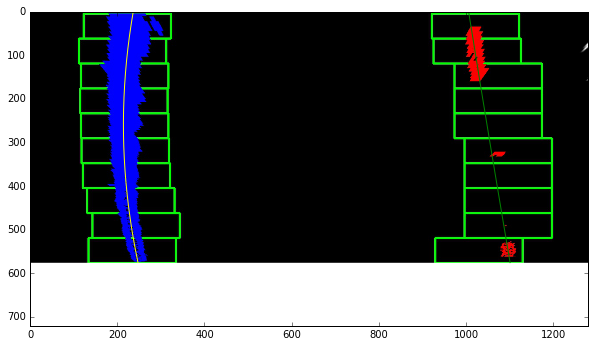

In [28]:
left_fit, right_fit, left_fitx, right_fitx  = find_lanes(warped, debug=True)

### Sample lanes that is unwarped from the above binary image

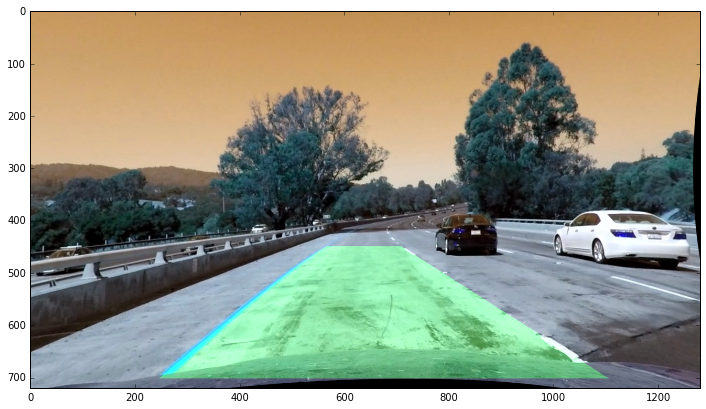

In [31]:
result_img = draw_lanes_on_image(warped, undistort_images[-1], left_fitx, right_fitx, Minv)
plt.figure(figsize=(12,12))
plt.imshow(result_img)

## Lanes detection on project video